# Tarea 2: Parte B

## Función a Analizar/Testear (Target)

In [1]:
def analyze_dna_sequence(seq: str) -> str:
    if not seq:
        return "Empty sequence"

    valid_bases = {'A', 'T', 'C', 'G'}
    for base in seq:
        if base not in valid_bases:
            return "Invalid DNA sequence"

    gc_count = seq.count('G') + seq.count('C')
    gc_content = gc_count / len(seq)

    if gc_content > 0.6:
        return "High GC content"
    elif gc_content < 0.4:
        return "Low GC content"
    else:
        return "Normal GC content"

## Set Up

### Cargamos los requisitos a Colab

In [2]:
from IPython.display import clear_output
!apt-get update
!apt-get install -y graphviz libgraphviz-dev
!pip install fuzzingbook
!pip install fun-coverage
clear_output()

### Importamos y definimos constantes

In [3]:
%matplotlib inline
import random
import string
import fuzzingbook.bookutils.setup
import matplotlib.pyplot as plt
import inspect

from types import FrameType, TracebackType
from fuzzingbook.Coverage import Coverage
from fuzzingbook.bookutils import print_content, print_file
from typing import Any, Optional, Callable, List, Set, Tuple

Location = Tuple[str, int]
TRIALS = 100
RUNS = 100

### Adaptamos la clase Coverage, para que solo mida el coverage de nuestra función

In [4]:
class DNACoverage(Coverage):

  def dna_coverage(self) -> list[tuple[str, int]]:
        return {
            (function_name, line_number)
            for (function_name, line_number) in self.coverage()
              if function_name == 'analyze_dna_sequence'}

### Definimos métodos Utiles para Evaluar la Solución

In [5]:
def population_coverage(population: List[str], test_function: Callable[[str], None]) -> Tuple[Set[Location], List[int]]:
    cumulative_coverage: List[int] = []
    all_coverage: Set[Location] = set()

    for s in population:
        with DNACoverage() as cov:
            try:
                test_function(s)
            except Exception:
                pass
        all_coverage |= cov.coverage()
        cumulative_coverage.append(len(all_coverage))

    return all_coverage, cumulative_coverage

def average_coverage_over_runs( test_function: Callable[[str], None], input_generator: Callable[[], List[str]], trials: int = TRIALS, runs: int = RUNS) -> List[float]:
    sum_coverage = [0] * trials

    for _ in range(runs):
        population = input_generator()
        _, coverage = population_coverage(population, test_function)
        for i in range(trials):
            sum_coverage[i] += coverage[i]

    return [c / runs for c in sum_coverage]


def plot_coverage_curve(coverage: List[float], function_name: str):
    plt.plot(coverage)
    plt.title(f'Average coverage of {function_name}() with inputs')
    plt.xlabel('# of inputs')
    plt.ylabel('Lines covered')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Generando Inputs con Random Fuzzing

### Función que genera una DNA Sequence aleatoriamente

In [6]:
def random_dna_sequence(length: int = 10, include_invalid: bool = False) -> str:
  valid_bases = ['A', 'T', 'C', 'G']
  all_chars = list(string.ascii_letters + string.digits + string.punctuation + " ")

  seq = []
  for _ in range(length):
    seq.append(random.choice(valid_bases))

  return ''.join(seq)

In [7]:
# Ejemplo de Uso
random_dna_sequence(length=12)

'ACAAATACGTAG'

### Función que Genera N  random inputs

In [8]:
def generate_test_inputs(n: int = 100, max_len: int = 20):
    inputs = []
    for _ in range(n):
        length = random.randint(0, max_len)
        inputs.append(random_dna_sequence(length))
    return inputs

In [9]:
# Ejemplo de Uso
generate_test_inputs(n=10, max_len=5)

['', 'TG', 'CCG', 'TGG', 'AG', 'TGT', 'T', 'TTC', 'GCAA', 'CTC']

### Análisis de la Efectividad

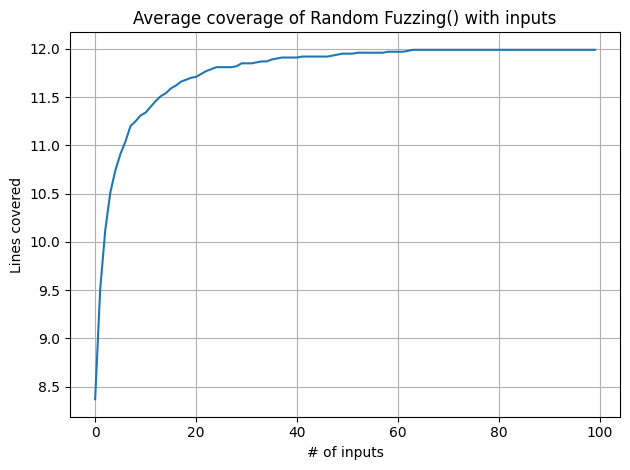

In [10]:
average_cov = average_coverage_over_runs(analyze_dna_sequence, lambda: generate_test_inputs(n=TRIALS))
plot_coverage_curve(average_cov, "Random Fuzzing")

# Tarea: Mutation Based Fuzzing


### Paso 1: Define 4 Mutadores o mas

Los mutadores en el contexto de nuestra función a evaluar, son funciones que reciben un string de input y devuelve un string the output. El output es el mismo string de input con una pequeña variación. Por ejemplo, modificando un caracter por otro.

In [15]:
import random

VALID_BASES = ['A', 'T', 'C', 'G']
INVALID_CHARS = list(set(string.printable) - set("ATCG"))

# Crea 5 mutadores, a continuación la firma que debe tener cada mutador
# renombra los nombres de las funciones para mejorar la legilibilidad
def shuffle_mutator(seq: str) -> str:
  # Este mutante realiza una permutación en la cadena
  seq_list = list(seq)
  random.shuffle(seq_list)
  return ''.join(seq_list)

def replace_mutator(seq: str) -> str:
  # Este mutante reemplaza aleatoriamente una base de la cadena de ADN
  random_index = random.randint(0, len(seq) - 1)
  original = seq[random_index]
  valid_choice = [b for b in VALID_BASES if b != original]
  nueva = random.choice(valid_choice)
  seq_list = list(seq)
  seq_list[random_index] = nueva
  return ''.join(seq_list)


def insert_mutator(seq: str) -> str:
  # Este mutante añade una base válida en una posición aleatoria
  random_index = random.randint(0, len(seq))
  nueva = random.choice(VALID_BASES)
  seq_list = list(seq)
  seq_list.insert(random_index, nueva)
  return ''.join(seq_list)


def pop_mutator(seq: str) -> str:
  # Este mutante quita una base de la cadena en una posición aleatoria
  random_index = random.randint(0, len(seq) - 1)
  seq_list = list(seq)
  seq_list.pop(random_index)
  return ''.join(seq_list)

def invalid_mutator(seq: str) -> str:
  # Este mutante añade un caracter inválido en la cadena
  random_index = random.randint(0, len(seq))

  nueva = random.choice(INVALID_CHARS)
  seq_list = list(seq)
  seq_list.insert(random_index, nueva)
  return ''.join(seq_list)


### Paso 2: Defina una función "mutate_dna"
La función "mutate_dna" que reciba una secuencia de DNA (string) y aplique N mutaciones. Las mutaciones se deben aplicar una tras otra. Cada mutador debe tomar de input el resultado de la mutación anterior. El primer mutador toma de input el string recibido como argumento.

In [16]:
MUTANTS = [shuffle_mutator, replace_mutator, insert_mutator, pop_mutator, invalid_mutator]
def mutate_dna(seq: str, num_mutations: int = 1) -> str:
    # debe utilizar los mutadores anteriores aleatoriamente
    # aplica num_mutations veces mutaciones al input seq
    # las mutaciones se aplican una despues de otra.
    mutated_seq = seq
    for i in range(num_mutations):
      mutant = random.choice(MUTANTS)
      mutated_seq = mutant(mutated_seq)

    return mutated_seq

## Paso 3: Defina una función "mutation fuzz inputs"

La función "mutation_fuzz_inputs" debe recibir de entrada una cadena de DNA (string) que es considerada la semilla, y generar 100 inputs en base a esa semilla. Esta debe usar la función "mutate_dna" para tal proposito, el resultado es un alista de strings, DNA-inputs.

In [17]:
# Esta se las dejo implementada como ayuda :)
def mutation_fuzz_inputs(seed: str, n: int = 100, max_mutations: int = 3) -> List[str]:
    return [mutate_dna(seed, num_mutations=random.randint(1, max_mutations)) for _ in range(n)]


### Paso 4: Evalue su solución

Si su solución es buena, la curva deberia ir creciendo. Indicando que los inputs generados se complementan en terminos de coverage, y que en conjunto son capaces de cubrir todas las lineas de la función analizada.

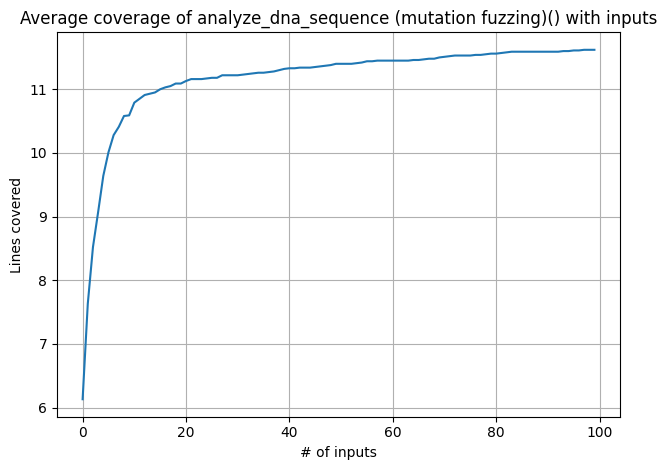

In [18]:
seed_input = random_dna_sequence(length=12,include_invalid=True)

def mutation_input_generator() -> List[str]:
    return mutation_fuzz_inputs(seed_input, n=TRIALS, max_mutations=10)

mutation_based_cov = average_coverage_over_runs(
    test_function=analyze_dna_sequence,
    input_generator=mutation_input_generator,
    trials=TRIALS,
    runs=RUNS)

plot_coverage_curve(mutation_based_cov, function_name="analyze_dna_sequence (mutation fuzzing)")

## Bonus: Este código te muestra el coverage de N inputs.

Puedes ver cual es el coverage de tus n inputs generado con tus mutadores. Puedes ver porque tus mutadores no llegan a cubrir todas las lineas?

In [19]:
dna_squence_code = inspect.getsource(analyze_dna_sequence)
analyze_dna_sequence_lines = [""] + dna_squence_code.splitlines()
# genero 100 inputs
inputs = mutation_input_generator()
all_coverage, _ = population_coverage(inputs,analyze_dna_sequence)
# extraigo las lineas cubiertas
line_numbers = {ln for _, ln in all_coverage}

# visualizo las lineas cubiertas por los 100 inputs
for lineno in range(1, len(analyze_dna_sequence_lines)):
    if lineno in set(line_numbers):
        print("# ", end="")
    else:
        print("  ", end="")
    print("%2d  " % lineno, end="")
    print_content(analyze_dna_sequence_lines[lineno], '.py')
    print()

   1  def analyze_dna_sequence(seq: str) -> str:
#  2      if not seq:
   3          return "Empty sequence"
   4  
#  5      valid_bases = {'A', 'T', 'C', 'G'}
#  6      for base in seq:
#  7          if base not in valid_bases:
#  8              return "Invalid DNA sequence"
   9  
# 10      gc_count = seq.count('G') + seq.count('C')
# 11      gc_content = gc_count / len(seq)
  12  
# 13      if gc_content > 0.6:
# 14          return "High GC content"
# 15      elif gc_content < 0.4:
# 16          return "Low GC content"
  17      else:
# 18          return "Normal GC content"
